In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import pickle

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from lightgbm import LGBMClassifier

In [6]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from yellowbrick.classifier import DiscriminationThreshold

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline

In [8]:
from sklearn.model_selection import RandomizedSearchCV

In [9]:
# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [10]:
from diabetes.reader import read_data
from diabetes.transformers import CategoricalConverter, FeatureAdder

In [11]:
def model_metrics(X, y, model, cv, cutpoint):
    f1_score_train = []
    f1_score_valid = []
    recall_train = []
    recall_valid = []
    precision_train = []
    precision_valid = []
    accuracy_train = []
    accuracy_valid = []

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        train_pred = np.where(model.predict_proba(X_train)[:, 1] > cutpoint, 1, 0)
        valid_pred = np.where(model.predict_proba(X_test)[:, 1] > cutpoint, 1, 0)
        
        f1_score_train.append(f1_score(y_train, train_pred))
        f1_score_valid.append(f1_score(y_test, valid_pred))
        
        recall_train.append(recall_score(y_train, train_pred))
        recall_valid.append(recall_score(y_test, valid_pred))

        precision_train.append(precision_score(y_train, train_pred))
        precision_valid.append(precision_score(y_test, valid_pred))

        accuracy_train.append(accuracy_score(y_train, train_pred))
        accuracy_valid.append(accuracy_score(y_test, valid_pred))

    result = pd.DataFrame(data={
    'metric': ['f1_score', 'recall', 'precision', 'accuracy'],
    'value': [np.mean(f1_score_valid), np.mean(recall_valid), np.mean(precision_valid),np.mean(accuracy_valid)]})
    result['value_perc'] = ["{0:.2f}%".format(val*100) for val in result['value']]
    return result

## Read data

In [12]:
data = read_data('../data/raw/diabetes_data_upload.csv')

### Data prep

In [13]:
pipeline = Pipeline([('FeatureAdder', FeatureAdder()), ('CategoricalConverter', CategoricalConverter())])

In [14]:
data = pipeline.fit_transform(data)

In [15]:
X, y = data.drop('class', axis=1), data['class']

## Baseline

### Melhor parâmetro de regularização C

In [18]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
Cs = [1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]

In [20]:
mean_train_auc = []
mean_valid_auc = []
std_train_auc = []
std_valid_auc = []
for c in Cs:
    temp_train_auc = []
    temp_valid_auc = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        reg_log = LogisticRegression(C=c, max_iter=500)
        reg_log.fit(X_train, y_train)
        temp_train_auc.append(roc_auc_score(y_train, reg_log.predict_proba(X_train)[:, 1]))
        temp_valid_auc.append(roc_auc_score(y_test, reg_log.predict_proba(X_test)[:, 1]))
    mean_train_auc.append(np.mean(temp_train_auc)) 
    std_train_auc.append(np.std(temp_train_auc))
    
    mean_valid_auc.append(np.mean(temp_valid_auc)) 
    std_valid_auc.append(np.std(temp_valid_auc))
idx = np.argmax(mean_valid_auc)
mean_auc, std_auc = mean_valid_auc[idx], std_valid_auc[idx]

In [ ]:
print(f'Best C {Cs[idx]} with mean auc {mean_auc} ± {std_auc}')
C = Cs[idx]

In [23]:
print(f'Best C {Cs[idx]} with Validation AUC of {mean_auc} ± {std_auc}')

Best C 2.7825594 with Validation AUC of 0.9784375000000001 ± 0.011730202736952189


### Best features using permutation importance

In [24]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
reg_log = LogisticRegression(C=C, max_iter=500)
reg_log.fit(X_train, y_train)

LogisticRegression(C=2.7825594, max_iter=500)

In [26]:
r = permutation_importance(reg_log, X_val, y_val,
                            n_repeats=30,
                            scoring='roc_auc',
                            random_state=42)

cols = []
mean_value = []
for i in r.importances_mean.argsort()[::-1]:
        cols.append(X.columns[i])
        mean_value.append(r.importances_mean[i])
        print(f"{X.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" ± {r.importances_std[i]:.3f}")

prop_main_symptoms_3 0.063 ± 0.018
gender   0.057 ± 0.013
prop_main_symptoms_6 0.047 ± 0.015
itching  0.016 ± 0.006
irritability 0.015 ± 0.008
sudden_weight_loss 0.014 ± 0.004
polydipsia 0.012 ± 0.006
polyuria 0.009 ± 0.005
genital_thrush 0.005 ± 0.005
age      0.005 ± 0.004
visual_blurring 0.004 ± 0.004
partial_paresis 0.003 ± 0.002
delayed_healing 0.003 ± 0.003
obesity  0.003 ± 0.001
weakness 0.002 ± 0.003
muscle_stiffness 0.001 ± 0.002
is_female_with_peak_age 0.000 ± 0.001
alopecia -0.000 ± 0.000
polyphagia -0.000 ± 0.002


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


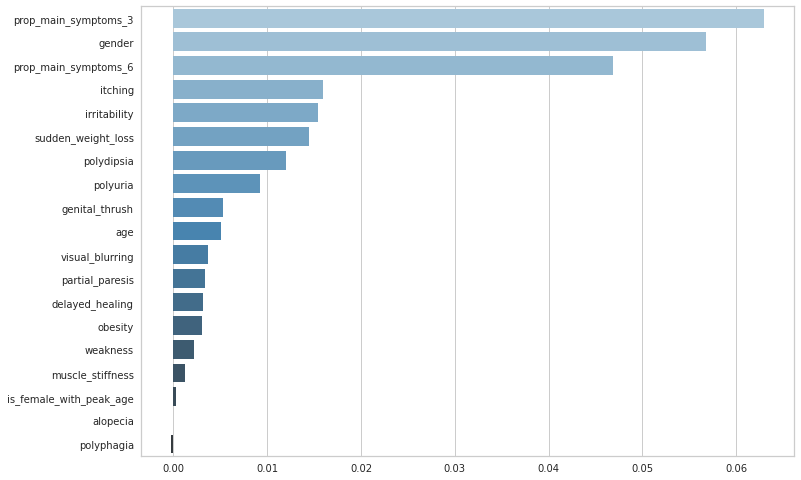

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x=mean_value, y=cols, palette="Blues_d", ax=ax)
plt.show()

## Final baseline model
* Removendo as piores cinco variáveis

In [28]:
best_columns_reglog  = cols[:-5]

In [29]:
train_auc = []
valid_auc = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[best_columns_reglog].iloc[train_index, :], X[best_columns_reglog].iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    reg_log = LogisticRegression(C=C, max_iter=500)
    reg_log.fit(X_train, y_train)
    train_auc.append(roc_auc_score(y_train, reg_log.predict_proba(X_train)[:, 1]))
    valid_auc.append(roc_auc_score(y_test, reg_log.predict_proba(X_test)[:, 1]))
mean_train_auc = np.mean(train_auc)
std_train_auc = np.std(train_auc)

mean_valid_auc = np.mean(valid_auc)
std_valid_auc = np.std(valid_auc)

In [30]:
print(f'Training AUC {mean_train_auc} ± {std_train_auc}')

Training AUC 0.9801967592592593 ± 0.0013675650001674147


In [31]:
print(f'K-Fold AUC {mean_valid_auc} ± {std_valid_auc}')

K-Fold AUC 0.9764062499999999 ± 0.012968750000000013


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


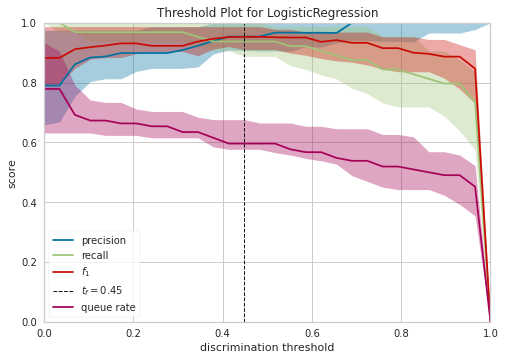

<AxesSubplot:title={'center':'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [32]:
reg_log = LogisticRegression(C=C, max_iter=500)
visualizer = DiscriminationThreshold(reg_log, cv=kfold)
visualizer.fit(X[best_columns_reglog], y)        # Fit the data to the visualizer
visualizer.show()  

In [33]:
cutpoint_reglog = 0.45

In [34]:
result_reg_log = model_metrics(X[best_columns_reglog], y, reg_log, kfold, cutpoint_reglog)

In [35]:
result_reg_log

,metric,value,value_perc
0,f1_score,0.946977,94.70%
1,recall,0.946875,94.69%
2,precision,0.949637,94.96%
3,accuracy,0.934615,93.46%


## Boosting

In [36]:
param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, ],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_iter = 300
lgb_model = LGBMClassifier(random_state=42, n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgb_model, 
    param_distributions=param_test, 
    n_iter=n_iter,
    scoring='roc_auc',
    cv=kfold,
    refit=True,
    random_state=42,
    verbose=True)

grid_search.fit(X, y)
opt_parameters =  grid_search.best_params_

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [37]:
train_auc = []
valid_auc = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    lgb_model = LGBMClassifier(**opt_parameters)
    lgb_model.fit(X_train, y_train)
    train_auc.append(roc_auc_score(y_train, lgb_model.predict_proba(X_train)[:, 1]))
    valid_auc.append(roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1]))
mean_train_auc = np.mean(train_auc)
std_train_auc = np.std(train_auc)

mean_valid_auc = np.mean(valid_auc)
std_valid_auc = np.std(valid_auc)

In [38]:
print(f'Training AUC {mean_train_auc} ± {std_train_auc}')

Training AUC 0.9865335648148147 ± 0.002124397045566824


In [39]:
print(f'K-Fold AUC {mean_valid_auc} ± {std_valid_auc}')

K-Fold AUC 0.9785937500000002 ± 0.00937630199292347


In [40]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
lgb_model = LGBMClassifier(**opt_parameters)
lgb_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.9806196329242519, learning_rate=0.08,
               max_depth=2, min_child_samples=111, min_child_weight=0.01,
               n_estimators=500, num_leaves=49, reg_alpha=0, reg_lambda=10,
               subsample=0.8320108470334848)

In [41]:
r = permutation_importance(lgb_model, X_val, y_val,
                            n_repeats=30,
                            scoring='roc_auc',
                            random_state=42)

cols = []
mean_value = []
for i in r.importances_mean.argsort()[::-1]:
        cols.append(X.columns[i])
        mean_value.append(r.importances_mean[i])
        print(f"{X.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" ± {r.importances_std[i]:.3f}")

prop_main_symptoms_3 0.071 ± 0.017
gender   0.043 ± 0.011
polyuria 0.021 ± 0.010
prop_main_symptoms_6 0.012 ± 0.008
itching  0.009 ± 0.004
polydipsia 0.009 ± 0.003
age      0.007 ± 0.007
partial_paresis 0.006 ± 0.003
delayed_healing 0.005 ± 0.005
alopecia 0.004 ± 0.003
visual_blurring 0.003 ± 0.002
weakness 0.002 ± 0.005
muscle_stiffness 0.001 ± 0.002
irritability 0.000 ± 0.000
genital_thrush 0.000 ± 0.000
polyphagia 0.000 ± 0.000
sudden_weight_loss 0.000 ± 0.000
obesity  0.000 ± 0.000
is_female_with_peak_age 0.000 ± 0.000


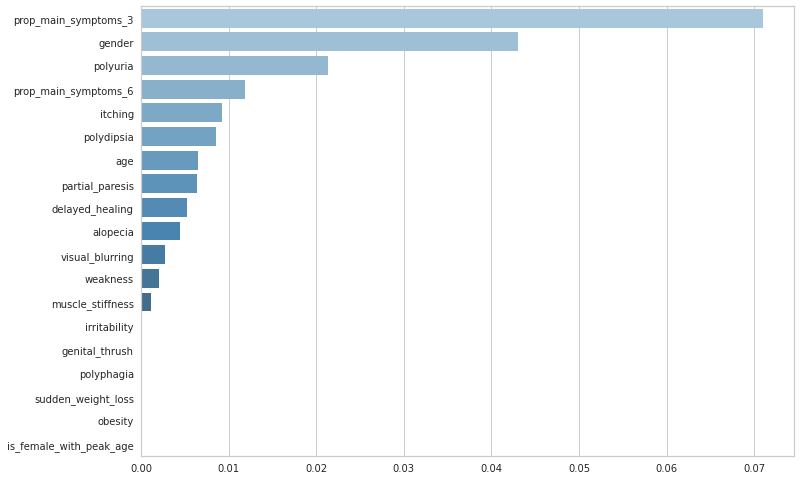

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x=mean_value, y=cols, palette="Blues_d", ax=ax)
plt.show()

In [43]:
best_columns_lgb  = cols[:-5]

In [44]:
train_auc = []
valid_auc = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[best_columns_lgb].iloc[train_index, :], X[best_columns_lgb].iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    lgb_model = LGBMClassifier(**opt_parameters)
    lgb_model.fit(X_train, y_train)
    train_auc.append(roc_auc_score(y_train, lgb_model.predict_proba(X_train)[:, 1]))
    valid_auc.append(roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1]))
mean_train_auc = np.mean(train_auc)
std_train_auc = np.std(train_auc)

mean_valid_auc = np.mean(valid_auc)
std_valid_auc = np.std(valid_auc)
print(f'Training AUC {mean_train_auc} ± {std_train_auc}')
print(f'K-Fold AUC {mean_valid_auc} ± {std_valid_auc}')

Training AUC 0.98555362654321 ± 0.002101321412747157
K-Fold AUC 0.9793749999999999 ± 0.011413738979843581


### Finding the best threshold

In [45]:
lgb_model = LGBMClassifier(**opt_parameters)

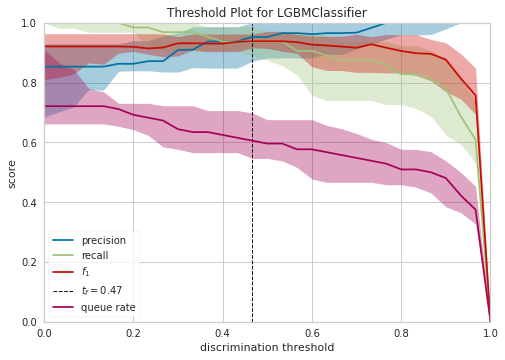

<AxesSubplot:title={'center':'Threshold Plot for LGBMClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [47]:
visualizer = DiscriminationThreshold(lgb_model, cv=kfold)
visualizer.fit(X[best_columns_lgb], y)        # Fit the data to the visualizer
visualizer.show()  

In [49]:
cutpoint_lgb = 0.47

In [51]:
result_lgb = model_metrics(X[best_columns_lgb], y, lgb_model, kfold, cutpoint_lgb)

In [52]:
import altair as alt

In [129]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [110]:
width = 500
height = 300
bars_lgb = alt.Chart(result_lgb).mark_bar().encode(
    x=alt.X('value:Q', axis=alt.Axis(format='%')),
    y=alt.Y('metric:N'),
    color='metric:N',
    text=alt.Text('value:Q'),
).properties(width=width, height=height, title='LightGBM')

text_lgb = bars_lgb.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='value_perc:N'
)
lgb_bar = (bars_lgb+text_lgb)

In [111]:
bars_reglog = alt.Chart(result_reg_log).mark_bar().encode(
    x=alt.X('value:Q', axis=alt.Axis(format='%')),
    y=alt.Y('metric:N'),
    color='metric:N',
    text=alt.Text('value:Q')
).properties(width=width, height=height, title='LogisticRegression')
text_reglog = bars_reglog.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='value_perc:N'
)
reglog_bar = (bars_reglog+text_reglog)

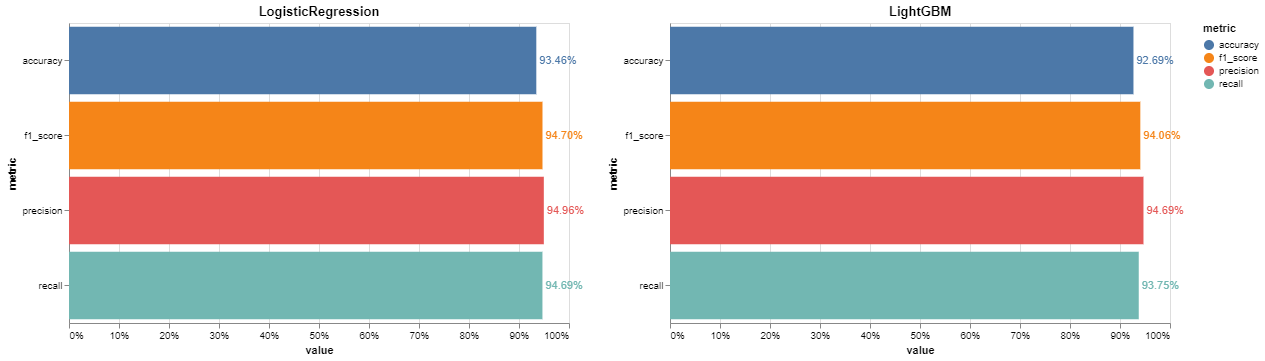

In [130]:
reglog_bar | lgb_bar

### Escolha do modelo

Basicamente a performance dos dois modelos é a mesma nas pastas de validação. Nesses casos é boa prática selecionar o modelo mais simples  - menor variância das estimativas. Isso faz com que a regressão logística seja um modelo mais robusto a longo prazo. Além disso, a interpretação da regressão logística é bastante intuitiva, enquanto um modelo de boosting teríamos que usar ferramentas como o SHAP. 

Talvez deveríamos volta a etapa de feature engineering para criarmos mais variáveis que ajudem a aumentar a performance dos modelos. Não me parece, dado ao empate entre o boosting e a regressão logística, que modelos mais complexos vão trazer mais ganhos.

In [126]:
# salvando o objeto com a regressão logistica
final_model = LogisticRegression(C=C, max_iter=500)
final_model.fit(X[best_columns_reglog], y)

LogisticRegression(C=2.7825594, max_iter=500)

In [127]:
model_obj = {
'model': final_model,
'best_c': c,
'transformers': pipeline,
'cutpoint': cutpoint_reglog,
'columns': best_columns_reglog
}

In [128]:
with open('../models/final_model.pkl', 'wb') as f:
    f.write(pickle.dumps(model_obj))